In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
from ast import literal_eval
from tqdm import tqdm

mean_vals = []
counts = []
max_vals = []
years = [i for i in range(2007, 2020)]
for year in tqdm(years):
    df_temp = pd.read_csv(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Common/data_v1_{year}.csv', compression='zip',
                          converters={'tokenized_text': literal_eval, 'lemmas': literal_eval})
    mean_val = df_temp.lemmas.apply(lambda x: len(set(x))).mean()
    mean_vals.append(mean_val)
    counts.append(df_temp.shape[0])
    max_val = df_temp.lemmas.apply(lambda x: len(set(x))).max()
    max_vals.append(max_val)
    print(year)
    print(mean_val)
    print(max_val)

  8%|▊         | 1/13 [00:08<01:44,  8.70s/it]

2007
4.977080630282667
294


 15%|█▌        | 2/13 [00:30<02:57, 16.14s/it]

2008
5.087528373152941
342


 23%|██▎       | 3/13 [01:14<04:49, 28.97s/it]

2009
6.130837112043004
346


 31%|███       | 4/13 [02:12<06:05, 40.56s/it]

2010
5.502786005374839
1258


 38%|███▊      | 5/13 [02:49<05:15, 39.39s/it]

2011
7.006454097831631
1177


 46%|████▌     | 6/13 [03:35<04:51, 41.65s/it]

2012
7.099790857900336
960


 54%|█████▍    | 7/13 [04:22<04:20, 43.37s/it]

2013
8.353054754608173
1053


 62%|██████▏   | 8/13 [05:21<04:00, 48.19s/it]

2014
9.52872758470789
1002


 69%|██████▉   | 9/13 [06:16<03:21, 50.47s/it]

2015
10.859131812207206
1095


 77%|███████▋  | 10/13 [07:07<02:31, 50.61s/it]

2016
13.026875288019056
1126


 85%|████████▍ | 11/13 [07:58<01:41, 50.51s/it]

2017
18.201335214178968
1144


 92%|█████████▏| 12/13 [08:51<00:51, 51.35s/it]

2018
23.429613043331496
957


100%|██████████| 13/13 [09:38<00:00, 44.49s/it]

2019
26.371627935679527
1150


In [ ]:
import numpy as np

np.sum((np.array(mean_vals) * np.array(counts)))/ np.array(counts).sum()

9.58592798246011

In [ ]:
np.max(max_vals)

1258

In [ ]:
from gensim.models import Word2Vec
import pandas as pd
from ast import literal_eval
from tqdm import tqdm

# Train and save models per each year
years = [i for i in range(2007, 2020)]
for year in tqdm(years):
    df_temp = pd.read_csv(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Common/data_v1_{year}.csv', compression='zip',
                          converters={'tokenized_text': literal_eval, 'lemmas': literal_eval})
    model = Word2Vec(sentences=df_temp.lemmas, vector_size=300, window=5, min_count=10, 
                 sg=1, negative=5, ns_exponent=0.75, workers=4)
    model.save(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/Word2vec/word2vec_{year}.model')

100%|██████████| 13/13 [1:08:17<00:00, 315.21s/it]


In [ ]:
# Functions for aligning word embeddings of different years
# Source: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8
import gensim
import numpy as np

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

In [ ]:
from gensim.models import Word2Vec

# Align word embeddings
years = [2007, 2014]

models_dict = {}

model_2019 = Word2Vec.load('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/Word2vec/word2vec_2019.model')
model_2014 = Word2Vec.load('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/Word2vec/word2vec_2014.model')
m_2019, m_2014 = intersection_align_gensim(model_2019, model_2014)
words = m_2014.wv.key_to_index

for year in years:
    model_2019 = Word2Vec.load('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/Word2vec/word2vec_2019.model')
    model_2 = Word2Vec.load(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/Word2vec/word2vec_{year}.model')
    m_2019, m_2 = intersection_align_gensim(model_2019, model_2, words=words)
    m_2_modified = smart_procrustes_align_gensim(m_2019, m_2, words=words)
    models_dict[f'm_{year}_modified'] = m_2_modified
    words = m_2019.wv.key_to_index

24970 24970
24970 24970
6453 6453
6453 6453
6453 6453
6453 6453


In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/Social media/Common/shared_words_social_media.json', 'w') as f:
    json.dump(words, f)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Compute cosine similarities
model_2007_modified = models_dict['m_2007_modified']
cosine_similarities ={}

for word in tqdm(model_2007_modified.wv.index_to_key):
    cosine_similarities[word] = cosine_similarity([model_2007_modified.wv[word]], 
                                                  [model_2019.wv[word]])[0][0]

100%|██████████| 6453/6453 [00:02<00:00, 3126.58it/s]


In [ ]:
model_2014_modified = models_dict['m_2014_modified']

In [ ]:
top_20 = sorted(cosine_similarities.items(), key=lambda item: item[1])[:20]

for word in top_20:
    print(word)
    print([w for w,v in model_2007_modified.wv.most_similar(word[0], topn=5)])
    print([w for w,v in model_2019.wv.most_similar(word[0], topn=5)])

('популярный', 0.18283693)
['ца', 'неудачник', 'верна', 'сука', 'ая']
['интригующий', 'диджей', 'знаменитость', 'дарий', 'набраться']
('десятый', 0.21911281)
['относиться', 'заботиться', 'пункт', 'ассоциироваться', 'большинство']
['марш', 'восьмой', 'ставка', 'сотый', 'седьмой']
('экономика', 0.22681837)
['география', 'физр', 'определиться', 'англ', 'рки']
['спрос', 'нгу', 'поступление', 'темп', 'рост']
('ца', 0.22907692)
['неудачник', 'поболтать', 'сме', 'верна', 'популярный']
['тож', 'скрипт', 'ия', 'еб', 'аз']
('мышь', 0.233466)
['вершина', 'грядущий', 'порог', 'приход', 'украсить']
['мышка', 'мутант', 'кролик', 'попа', 'неий']
('шестой', 0.23642892)
['разослать', 'определять', 'скрипт', 'присылать', 'удалённый']
['седьмой', 'восьмой', 'пятый', 'четв', 'четвёртый']
('металлический', 0.23848952)
['корпус', 'отработать', 'шопинг', 'медведь', 'сб']
['полоска', 'иероглиф', 'попа', 'клей', 'протез']
('ом', 0.24324709)
['член', 'рвать', 'микроволновка', 'доступ', 'системный']
['маня', 'ма

100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


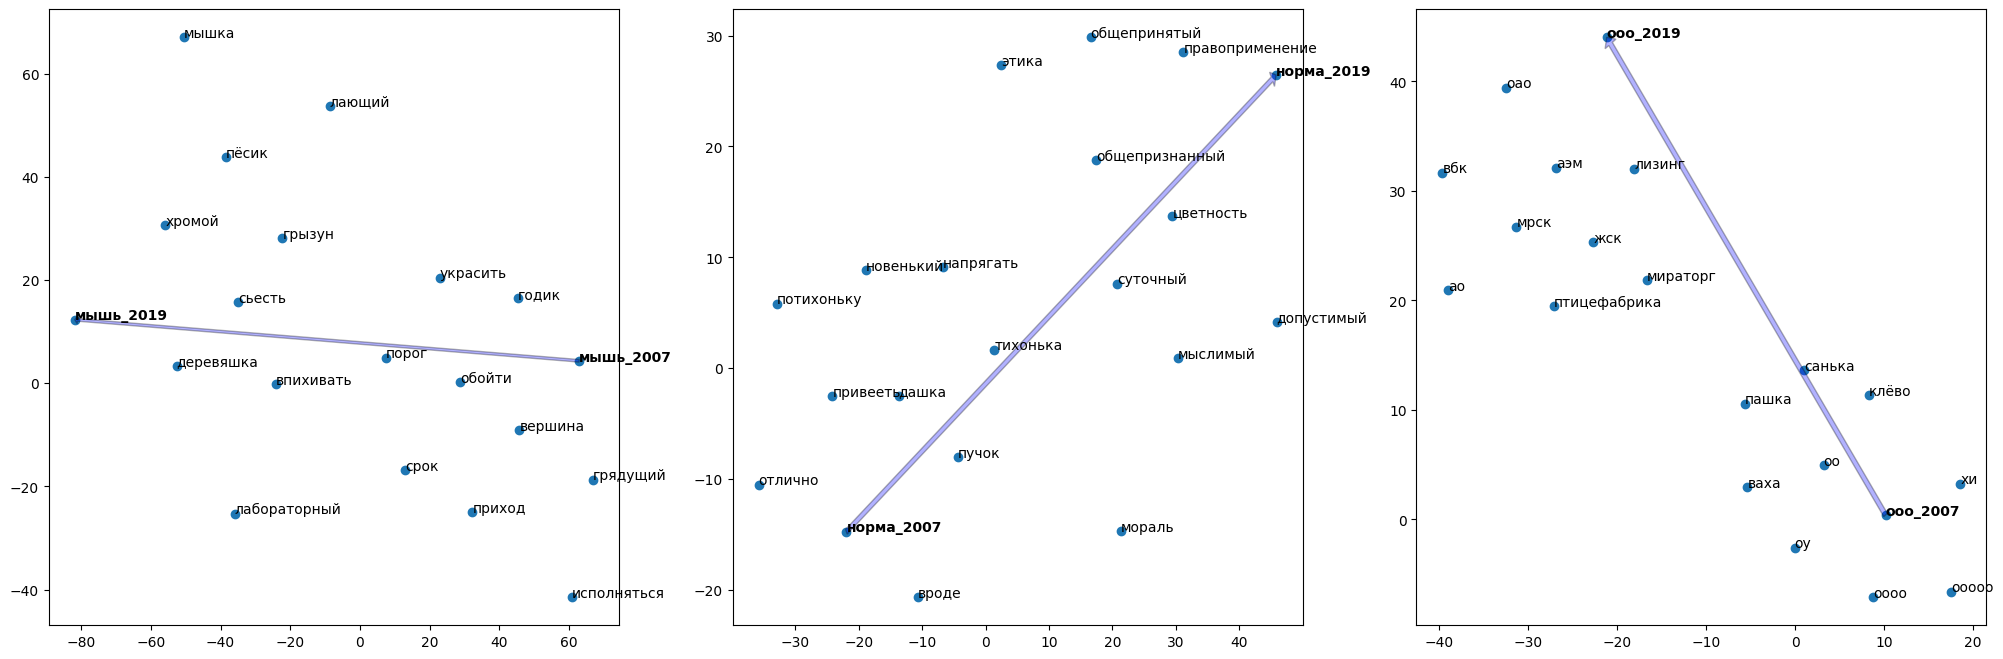

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

words = ['мышь', 'норма', 'ооо']

model_2019 = Word2Vec.load('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/Social media/Word2vec/word2vec_2019.model')
vectors_2019 = model_2019.wv
vectors_2007 = model_2007_modified.wv

points = []
all_keys = []

for word in tqdm(words):
    key_word_embed = [vectors_2007[word], vectors_2019[word]]                   
    most_similar = {}                 
    similars_2007 = [x[0] for x in vectors_2007.most_similar(vectors_2007[word], topn=10)]
    similars_2019 = [x[0] for x in vectors_2019.most_similar(vectors_2019[word], topn=10)]

    for w in similars_2007:
          if w == word:
              continue
          if w not in most_similar:
              w_embed = vectors_2007[w]
              most_similar[w] = w_embed

    for w in similars_2019:
          if w == word:
              continue
          if w not in most_similar:
              w_embed = vectors_2019[w]
              most_similar[w] = w_embed

    # Fit t-SNE
    keys = [key for key in most_similar.keys()]
    values = [most_similar[key] for key in keys]
    keys.extend([f'{word}_2007', f'{word}_2019'])
    values.extend(key_word_embed)
    mat = np.array(values)
    model = TSNE(n_components=2, random_state=0, init='pca', perplexity=10)
    fitted = model.fit_transform(mat)

    points.append(fitted)
    all_keys.append(keys)

fig, ax = plt.subplots(1, 3)

fig.set_figheight(8)
fig.set_figwidth(25)

for j in range(3):
    fitted = points[j]
    x = fitted[:, 0]
    y = fitted[:, 1]
    keys = all_keys[j]

    ax[j].scatter(x, y)

    for i, txt in enumerate(keys):
        if len(keys) - i <= 2:
            ax[j].annotate(txt, (x[i], y[i]), weight='bold')
        else:
            ax[j].annotate(txt, (x[i], y[i]))
    
    ax[j].arrow(fitted[-2, 0], fitted[-2, 1], (fitted[-1, 0] - fitted[-2, 0]), 
              (fitted[-1, 1] - fitted[-2, 1]), facecolor='blue', alpha=0.3, width=0.5,
              head_length=0.75, length_includes_head=True)
fig.savefig(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Vectors/sm_w2v.png')